<h1><center>Music Recommender System</center></h1>

<img src="https://www.incimages.com/uploaded_files/image/1920x1080/getty_626660256_2000108620009280158_379902.jpg" width=750 height=7500 />

This will detail all of the steps involved in creating this music recommender system. This code is based on the google colab notebook and educational code available at: 

https://colab.research.google.com/github/google/eng-edu/blob/main/ml/recommendation-systems/recommendation-systems.ipynb?utm_source=ss-recommendation-systems&utm_campaign=colab-external&utm_medium=referral&utm_content=recommendation-systems#scrollTo=StMo4lDmLqpc 


#### The notebook is split into 4 sections:

1) Building rating matrix/ Calculating error

2) Training the matrix factorisation model

3) Inspecting embeddings

4) Regularisation in matrix factorisation



## Import required dependencies

In [1]:
from __future__ import print_function
import seaborn as sns
import numpy as np
import pandas as pd
import collections
from mpl_toolkits.mplot3d import Axes3D
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.logging.set_verbosity(tf.logging.ERROR)

Instructions for updating:
non-resource variables are not supported in the long term


## 1) Preliminaries

In [2]:
artists = pd.read_csv('../Data/artists.dat', sep='	')
tags = pd.read_csv('../Data/tags.dat', sep='	', encoding='latin-1')
user_artists = pd.read_csv('../Data/user_artists.dat', sep='	')
user_friends = pd.read_csv('../Data/user_friends.dat', sep='	')
user_tagged_artists_tstamp = pd.read_csv('../Data/user_taggedartists-timestamps.dat', sep='	')
user_tagged_artists = pd.read_csv('../Data/user_taggedartists.dat', sep='	')

We create a function to be used later for splitting the data in testing and training sets

In [3]:
# Split the data into training and test sets.
def split_dataframe(df, holdout_fraction=0.1):
    test = df.sample(frac=holdout_fraction, replace=False)
    train = df[~df.index.isin(test.index)]
    return train, test

### Building matrix

We design a function that maps the ```user_artists``` data to a tensorflow sparsetensor representation. Most users will not have rated each artist so this is full of 0's and hence becomes a very large matrix. This function allows us to efficiently capture this data

In [4]:
def build_rating_sparse_tensor(user_artists_df):
    indices = user_artists_df[['userID', 'artistID']].values
    values = user_artists_df['weight'].values
    return tf.SparseTensor(
        indices=indices,
        values=values,
        dense_shape=[len(user_artists['userID'].unique()), len(artists['id'].unique())])

### Calculating the error

The model approximates the ratings matrix by a low-rank product. We need a way to measure the approximation error. We'll start by using the Mean Squared Error of observed entries only. It is defined as

$$
\begin{align*}
\text{MSE}(A, UV^\top)
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - (UV^\top)_{ij})^2} \\
&= \frac{1}{|\Omega|}\sum_{(i, j) \in\Omega}{( A_{ij} - \langle U_i, V_j\rangle)^2}
\end{align*}
$$

The function below is created to calculate this

In [5]:
def sparse_mean_square_error(sparse_ratings, user_embeddings, music_embeddings):
    predictions = tf.reduce_sum(
        tf.gather(user_embeddings, sparse_ratings.indices[:, 0]) *
        tf.gather(music_embeddings, sparse_ratings.indices[:, 1]),
        axis=1)
    loss = tf.losses.mean_squared_error(sparse_ratings.values, predictions)
    return loss

## 2) Training the Matrix Factorization model

### Collaborative Filtering Model (CF Model)
This class trains a matrix factorization model. Stochastic gradient descent is used in the function as the optimiser.


In [6]:
class CFModel(object):
    def __init__(self, embedding_vars, loss, metrics=None):
        self._embedding_vars = embedding_vars
        self._loss = loss
        self._metrics = metrics
        self._embeddings = {k: None for k in embedding_vars}
        self._session = None

    @property
    def embeddings(self):
        return self._embeddings

    def train(self, num_iterations=100, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
        with self._loss.graph.as_default():
            opt = optimizer(learning_rate)
            train_op = opt.minimize(self._loss)
            local_init_op = tf.group(
              tf.variables_initializer(opt.variables()),
              tf.local_variables_initializer())
            if self._session is None:
                self._session = tf.Session()
                with self._session.as_default():
                    self._session.run(tf.global_variables_initializer())
                    self._session.run(tf.tables_initializer())
                    tf.train.start_queue_runners()

        with self._session.as_default():
            local_init_op.run()
            iterations = []
            metrics = self._metrics or ({},)
            metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

            # Train and append results.
            for i in range(num_iterations + 1):
                _, results = self._session.run((train_op, metrics))
                if (i % 10 == 0) or i == num_iterations:
                    print("\r iteration %d: " % i + ", ".join(["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                        end='')
                    iterations.append(i)
                    for metric_val, result in zip(metrics_vals, results):
                        for k, v in result.items():
                            metric_val[k].append(v)

            for k, v in self._embedding_vars.items():
                self._embeddings[k] = v.eval()

            if plot_results:
                # Plot the metrics.
                num_subplots = len(metrics)+1
                fig = plt.figure()
                fig.set_size_inches(num_subplots*10, 8)
                for i, metric_vals in enumerate(metrics_vals):
                    ax = fig.add_subplot(1, num_subplots, i+1)
                    for k, v in metric_vals.items():
                        ax.plot(iterations, v, label=k)
                    ax.set_xlim([1, num_iterations])
                    ax.legend()
            return results

### Build the model

We build the model that uses the `sparse_mean_square_error` function. We write a function that builds a `CFModel` by creating the embedding variables and the train and test losses.

In [7]:
def build_model(ratings, embedding_dim=3, init_stddev=1.):
    
    # Split the ratings DataFrame into train and test.
    train_ratings, test_ratings = split_dataframe(ratings)
    # SparseTensor representation of the train and test datasets.
    A_train = build_rating_sparse_tensor(train_ratings)
    A_test = build_rating_sparse_tensor(test_ratings)
    # Initialize the embeddings using a normal distribution.
    U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
    V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
    train_loss = sparse_mean_square_error(A_train, U, V)
    test_loss = sparse_mean_square_error(A_test, U, V)
    metrics = {
      'train_error': train_loss,
      'test_error': test_loss
  }
    embeddings = {
      "userID": U,
      "artistID": V
  }
    return CFModel(embeddings, train_loss, [metrics])

In [8]:
user_artists

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983
...,...,...,...
92829,2100,18726,337
92830,2100,18727,297
92831,2100,18728,281
92832,2100,18729,280


 We convert our columns into the appropriate data type before running it through the model

### Changing user id and artist id

We get errors when using the user data as is, as the user ID values and artist ID values are not in sequential order and are often higher than the index value so we will change them so they run from 0-1891, and 0-17631 respectively.

In [9]:
user_artists.userID.unique().astype(int).max()

2100

In [10]:
user_artists.artistID.unique().astype(int).max()

18745

In [11]:
def return_inverse(x):
    p = np.zeros(x.max()+1, dtype=bool)
    p[x] = 1

    p2 = np.empty(x.max()+1, dtype=np.uint64)
    c = p.sum()
    p2[p] = np.arange(c)    
    out = p2[x]
    return out

In [12]:
inverse_user_id = return_inverse(user_artists.userID)
inverse_user_id

array([   0,    0,    0, ..., 1891, 1891, 1891], dtype=uint64)

In [13]:
inverse_artist_id = return_inverse(user_artists.artistID)
inverse_artist_id

array([   45,    46,    47, ..., 17617, 17618, 17619], dtype=uint64)

In [14]:
# Replace id columns
user_artists['userID'] = inverse_user_id
user_artists['artistID'] = inverse_artist_id

In [15]:
user_artists.describe()

,userID,artistID,weight
count,92834.000000,92834.000000,92834.00000
mean,944.222483,3235.736724,745.24393
std,546.751074,4197.216910,3751.32208
min,0.000000,0.000000,1.00000
25%,470.000000,430.000000,107.00000
50%,944.000000,1237.000000,260.00000
75%,1416.000000,4266.000000,614.00000
max,1891.000000,17631.000000,352698.00000


We can see the userID now has a max value of 1,891 and artistID has a max value of 17,631

### Normalisation

The variety in weights are very large which will cause issues with our ```CFModel``` so we normalise these values between a value of 0-1 

The code below can be uncommented to try a z score normalisation for different results

In [16]:
# copy the data
user_artists_norm = user_artists.copy()
  
# apply normalization techniques by Column weight
column = 'weight'
user_artists_norm[column] = (user_artists_norm[column] - user_artists_norm[column].min()) / (user_artists_norm[column].max() - user_artists_norm[column].min())    

# z score normalisation
#user_artists_norm[column] = (user_artists_norm[column] - user_artists_norm[column].mean()) / user_artists_norm[column].std()    
  
# view normalized data
user_artists_norm.head()

,userID,artistID,weight
0,0,45,0.039360
1,0,46,0.033142
2,0,47,0.032181
3,0,48,0.029201
4,0,49,0.025467


### Build the CF Model and train it

2021-12-01 16:12:45.780764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 iteration 10: train_error=1.524332, test_error=1.642613

 iteration 40: train_error=0.956328, test_error=1.267085

 iteration 70: train_error=0.670282, test_error=1.068851

 iteration 100: train_error=0.499101, test_error=0.943451

 iteration 130: train_error=0.386849, test_error=0.856122

 iteration 160: train_error=0.308792, test_error=0.791526

 iteration 190: train_error=0.252189, test_error=0.741698

 iteration 220: train_error=0.209804, test_error=0.702049

 iteration 250: train_error=0.177238, test_error=0.669728

 iteration 280: train_error=0.151679, test_error=0.642862

 iteration 310: train_error=0.131255, test_error=0.620171

 iteration 340: train_error=0.114679, test_error=0.600747

 iteration 370: train_error=0.101043, test_error=0.583929

 iteration 400: train_error=0.089692, test_error=0.569223

 iteration 430: train_error=0.080142, test_error=0.556252

 iteration 460: train_error=0.072032, test_error=0.544724

 iteration 490: train_error=0.065086, test_error=0.534411

 iteration 520: train_error=0.059092, test_error=0.525129

 iteration 550: train_error=0.053883, test_error=0.516730

 iteration 580: train_error=0.049327, test_error=0.509093

 iteration 610: train_error=0.045320, test_error=0.502119

 iteration 640: train_error=0.041777, test_error=0.495725

 iteration 670: train_error=0.038629, test_error=0.489840

 iteration 700: train_error=0.035820, test_error=0.484407

 iteration 730: train_error=0.033301, test_error=0.479375

 iteration 750: train_error=0.031765, test_error=0.476221

 iteration 780: train_error=0.029649, test_error=0.471766

 iteration 810: train_error=0.027735, test_error=0.467609

 iteration 830: train_error=0.026558, test_error=0.464990

 iteration 860: train_error=0.024926, test_error=0.461270

 iteration 890: train_error=0.023437, test_error=0.457780

 iteration 910: train_error=0.022516, test_error=0.455570

 iteration 940: train_error=0.021230, test_error=0.452418

 iteration 970: train_error=0.020050, test_error=0.449446

 iteration 1000: train_error=0.018963, test_error=0.446639

[{'train_error': 0.018963082, 'test_error': 0.44663915}]

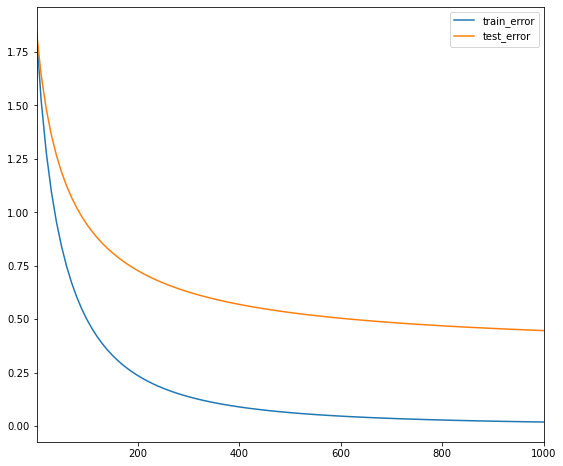

In [17]:
model = build_model(user_artists_norm, embedding_dim=30, init_stddev=0.5)
model.train(num_iterations=1000, learning_rate=10)

## 3) Inspecting the Embeddings

We look at the recommendations of the system using the dot product and cosine similarity which are two different similarity measures. We create a nearest neighbours function to recommend similar artists.

In [18]:
DOT = 'dot'
COSINE = 'cosine'
def compute_scores(query_embedding, item_embeddings, measure=DOT):

    u = query_embedding
    V = item_embeddings
    if measure == COSINE:
        V = V / np.linalg.norm(V, axis=1, keepdims=True)
        u = u / np.linalg.norm(u)
    scores = u.dot(V.T)
    return scores

In [19]:
def artist_neighbors(model, title_substring, measure=DOT, k=6):
  ids =  artists[artists['name'].str.contains(title_substring)].index.values
  titles = artists.iloc[ids]['name'].values
  if len(titles) == 0:
    raise ValueError("Found no artists with title %s" % title_substring)
  print("Nearest neighbors of : %s." % titles[0])
  if len(titles) > 1:
    print("[Found more than one matching artist. Other candidates: {}]".format(
        ", ".join(titles[1:])))
  artistID = ids[0]
  scores = compute_scores(
      model.embeddings["artistID"][artistID], model.embeddings["artistID"],
      measure)
  score_key = measure + ' score'
  df = pd.DataFrame({
      score_key: list(scores),
      'names': artists['name']
  })
  display.display(df.sort_values([score_key], ascending=False).head(k))

### Testing

We input an artist to see what recommendations our system returns to us

In [20]:
artist_neighbors(model, "Johnny Cash", DOT)
artist_neighbors(model, "Johnny Cash", COSINE)

Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
7371,3.564784,Yatu
4237,3.213859,Galneryus
2350,3.034864,Audrey Horne
14097,2.985254,Gabriel Ananda
7087,2.962192,Stray Cats
9062,2.926044,Billy Murray


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
4047,0.646658,Smokie
7087,0.630746,Stray Cats
1819,0.624069,Chaka Khan
7371,0.615773,Yatu
2350,0.611446,Audrey Horne


These results are interesting but it seems our system could be improved upon.

### Model initialisation

It seems the initialisation parameters may play a factor in the results of our system as artists with few ratings may have had their embeddings initialised with a high norm. We use regularisation to combat this by adjusting the value of ```init_stdev``` (previously at 0.5 now changed to 0.05)

 iteration 10: train_error=0.000308, test_error=0.000294

 iteration 40: train_error=0.000307, test_error=0.000293

 iteration 70: train_error=0.000305, test_error=0.000292

 iteration 100: train_error=0.000304, test_error=0.000291

 iteration 130: train_error=0.000302, test_error=0.000290

 iteration 150: train_error=0.000301, test_error=0.000290

 iteration 180: train_error=0.000300, test_error=0.000289

 iteration 210: train_error=0.000298, test_error=0.000288

 iteration 240: train_error=0.000297, test_error=0.000288

 iteration 270: train_error=0.000296, test_error=0.000287

 iteration 300: train_error=0.000294, test_error=0.000286

 iteration 330: train_error=0.000293, test_error=0.000285

 iteration 360: train_error=0.000292, test_error=0.000285

 iteration 380: train_error=0.000291, test_error=0.000284

 iteration 410: train_error=0.000289, test_error=0.000283

 iteration 440: train_error=0.000288, test_error=0.000283

 iteration 460: train_error=0.000287, test_error=0.000282

 iteration 480: train_error=0.000286, test_error=0.000282

 iteration 500: train_error=0.000286, test_error=0.000281

 iteration 530: train_error=0.000284, test_error=0.000281

 iteration 560: train_error=0.000283, test_error=0.000280

 iteration 590: train_error=0.000282, test_error=0.000279

 iteration 620: train_error=0.000281, test_error=0.000279

 iteration 650: train_error=0.000280, test_error=0.000278

 iteration 680: train_error=0.000278, test_error=0.000277

 iteration 710: train_error=0.000277, test_error=0.000277

 iteration 740: train_error=0.000276, test_error=0.000276

 iteration 770: train_error=0.000275, test_error=0.000275

 iteration 800: train_error=0.000274, test_error=0.000275

 iteration 830: train_error=0.000273, test_error=0.000274

 iteration 860: train_error=0.000272, test_error=0.000274

 iteration 890: train_error=0.000271, test_error=0.000273

 iteration 920: train_error=0.000269, test_error=0.000273

 iteration 950: train_error=0.000268, test_error=0.000272

 iteration 980: train_error=0.000267, test_error=0.000271

 iteration 1000: train_error=0.000267, test_error=0.000271Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
712,0.099054,Johnny Cash
9476,0.074225,J. Tillman
783,0.056667,Thalía
14760,0.056656,Kuolleet Kukat
14430,0.056206,bso
11049,0.055591,Peter Hammill


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
9476,0.674250,J. Tillman
14430,0.623293,bso
2351,0.609271,Karnivool
1850,0.597485,Thousand Foot Krutch
16376,0.571668,The Boy Least Likely To


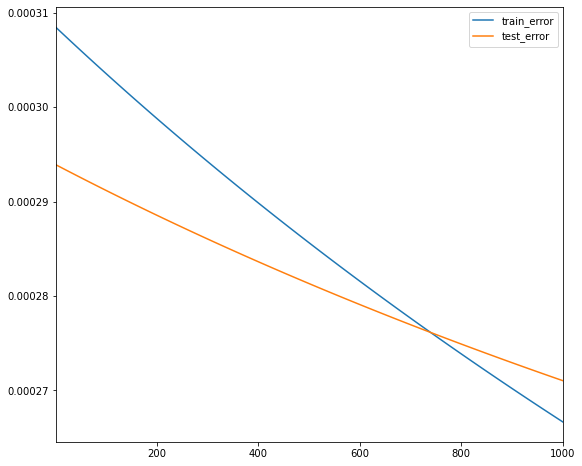

In [21]:
# Solution
model_lowinit = build_model(user_artists_norm, embedding_dim=30, init_stddev=0.05)
model_lowinit.train(num_iterations=1000, learning_rate=10.)
artist_neighbors(model_lowinit, "Johnny Cash", DOT)
artist_neighbors(model_lowinit, "Johnny Cash", COSINE)
#movie_embedding_norm([model, model_lowinit])

## 4) Regularization In Matrix Factorization

In the code above, loss was defined as the mean squared error on the observed part of the rating matrix.  This can often cause issues when the model does not learn how to place the embeddings of irrelevant artists. This is called *folding*.

We add some regularization terms to deal with this problem:
- Regularization of the model parameters. This is a common regularization term on the embedding matrices, given by 
$$
r(U, V) =  \frac{1}{N} \sum_i \|U_i\|^2 + \frac{1}{M}\sum_j \|V_j\|^2
$$
- A global prior that pushes the prediction of any pair towards zero, called the *gravity* term. This is given by 
$$
g(U, V) = \frac{1}{MN} \sum_{i = 1}^N \sum_{j = 1}^M \langle U_i, V_j \rangle^2
$$

Total loss can now be calculated as:
$$
\frac{1}{|\Omega|}\sum_{(i, j) \in \Omega} (A_{ij} - \langle U_i, V_j\rangle)^2 + \lambda _r r(U, V) + \lambda_g g(U, V)
$$

In [22]:

def gravity(U, V):
  return 1. / (U.shape[0].value*V.shape[0].value) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_dataframe(ratings)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0].value + tf.reduce_sum(V*V)/V.shape[0].value)
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_error_observed': error_train,
      'test_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"userId": U, "artistID": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

We build the regularised model and observe the results

 iteration 10: train_error_observed=0.000338, test_error_observed=0.000248, observed_loss=0.000338, regularization_loss=0.017152, gravity_loss=0.000210

 iteration 30: train_error_observed=0.000317, test_error_observed=0.000228, observed_loss=0.000317, regularization_loss=0.016352, gravity_loss=0.000190

 iteration 50: train_error_observed=0.000297, test_error_observed=0.000211, observed_loss=0.000297, regularization_loss=0.015614, gravity_loss=0.000173

 iteration 70: train_error_observed=0.000280, test_error_observed=0.000194, observed_loss=0.000280, regularization_loss=0.014934, gravity_loss=0.000156

 iteration 90: train_error_observed=0.000264, test_error_observed=0.000180, observed_loss=0.000264, regularization_loss=0.014306, gravity_loss=0.000142

 iteration 110: train_error_observed=0.000251, test_error_observed=0.000167, observed_loss=0.000251, regularization_loss=0.013726, gravity_loss=0.000129

 iteration 130: train_error_observed=0.000238, test_error_observed=0.000155, observed_loss=0.000238, regularization_loss=0.013190, gravity_loss=0.000117

 iteration 150: train_error_observed=0.000227, test_error_observed=0.000144, observed_loss=0.000227, regularization_loss=0.012693, gravity_loss=0.000106

 iteration 170: train_error_observed=0.000217, test_error_observed=0.000135, observed_loss=0.000217, regularization_loss=0.012234, gravity_loss=0.000096

 iteration 190: train_error_observed=0.000208, test_error_observed=0.000126, observed_loss=0.000208, regularization_loss=0.011807, gravity_loss=0.000087

 iteration 210: train_error_observed=0.000199, test_error_observed=0.000118, observed_loss=0.000199, regularization_loss=0.011412, gravity_loss=0.000079

 iteration 230: train_error_observed=0.000192, test_error_observed=0.000111, observed_loss=0.000192, regularization_loss=0.011045, gravity_loss=0.000072

 iteration 250: train_error_observed=0.000185, test_error_observed=0.000104, observed_loss=0.000185, regularization_loss=0.010704, gravity_loss=0.000065

 iteration 270: train_error_observed=0.000179, test_error_observed=0.000099, observed_loss=0.000179, regularization_loss=0.010386, gravity_loss=0.000059

 iteration 290: train_error_observed=0.000174, test_error_observed=0.000093, observed_loss=0.000174, regularization_loss=0.010090, gravity_loss=0.000053

 iteration 310: train_error_observed=0.000169, test_error_observed=0.000089, observed_loss=0.000169, regularization_loss=0.009813, gravity_loss=0.000048

 iteration 330: train_error_observed=0.000164, test_error_observed=0.000084, observed_loss=0.000164, regularization_loss=0.009555, gravity_loss=0.000044

 iteration 350: train_error_observed=0.000160, test_error_observed=0.000080, observed_loss=0.000160, regularization_loss=0.009314, gravity_loss=0.000040

 iteration 370: train_error_observed=0.000157, test_error_observed=0.000077, observed_loss=0.000157, regularization_loss=0.009088, gravity_loss=0.000036

 iteration 390: train_error_observed=0.000153, test_error_observed=0.000074, observed_loss=0.000153, regularization_loss=0.008876, gravity_loss=0.000033

 iteration 410: train_error_observed=0.000151, test_error_observed=0.000071, observed_loss=0.000151, regularization_loss=0.008677, gravity_loss=0.000030

 iteration 430: train_error_observed=0.000148, test_error_observed=0.000068, observed_loss=0.000148, regularization_loss=0.008490, gravity_loss=0.000027

 iteration 450: train_error_observed=0.000145, test_error_observed=0.000066, observed_loss=0.000145, regularization_loss=0.008314, gravity_loss=0.000025

 iteration 470: train_error_observed=0.000143, test_error_observed=0.000063, observed_loss=0.000143, regularization_loss=0.008148, gravity_loss=0.000022

 iteration 490: train_error_observed=0.000141, test_error_observed=0.000061, observed_loss=0.000141, regularization_loss=0.007991, gravity_loss=0.000020

 iteration 510: train_error_observed=0.000140, test_error_observed=0.000060, observed_loss=0.000140, regularization_loss=0.007842, gravity_loss=0.000018

 iteration 530: train_error_observed=0.000138, test_error_observed=0.000058, observed_loss=0.000138, regularization_loss=0.007702, gravity_loss=0.000017

 iteration 550: train_error_observed=0.000136, test_error_observed=0.000057, observed_loss=0.000136, regularization_loss=0.007568, gravity_loss=0.000015

 iteration 570: train_error_observed=0.000135, test_error_observed=0.000055, observed_loss=0.000135, regularization_loss=0.007441, gravity_loss=0.000014

 iteration 590: train_error_observed=0.000134, test_error_observed=0.000054, observed_loss=0.000134, regularization_loss=0.007320, gravity_loss=0.000012

 iteration 610: train_error_observed=0.000133, test_error_observed=0.000053, observed_loss=0.000133, regularization_loss=0.007205, gravity_loss=0.000011

 iteration 630: train_error_observed=0.000132, test_error_observed=0.000052, observed_loss=0.000132, regularization_loss=0.007095, gravity_loss=0.000010

 iteration 650: train_error_observed=0.000131, test_error_observed=0.000051, observed_loss=0.000131, regularization_loss=0.006990, gravity_loss=0.000009

 iteration 670: train_error_observed=0.000130, test_error_observed=0.000050, observed_loss=0.000130, regularization_loss=0.006889, gravity_loss=0.000008

 iteration 690: train_error_observed=0.000129, test_error_observed=0.000049, observed_loss=0.000129, regularization_loss=0.006792, gravity_loss=0.000008

 iteration 710: train_error_observed=0.000129, test_error_observed=0.000049, observed_loss=0.000129, regularization_loss=0.006700, gravity_loss=0.000007

 iteration 730: train_error_observed=0.000128, test_error_observed=0.000048, observed_loss=0.000128, regularization_loss=0.006610, gravity_loss=0.000006

 iteration 750: train_error_observed=0.000128, test_error_observed=0.000048, observed_loss=0.000128, regularization_loss=0.006524, gravity_loss=0.000006

 iteration 770: train_error_observed=0.000127, test_error_observed=0.000047, observed_loss=0.000127, regularization_loss=0.006441, gravity_loss=0.000005

 iteration 790: train_error_observed=0.000127, test_error_observed=0.000047, observed_loss=0.000127, regularization_loss=0.006360, gravity_loss=0.000005

 iteration 810: train_error_observed=0.000126, test_error_observed=0.000046, observed_loss=0.000126, regularization_loss=0.006282, gravity_loss=0.000004

 iteration 830: train_error_observed=0.000126, test_error_observed=0.000046, observed_loss=0.000126, regularization_loss=0.006207, gravity_loss=0.000004

 iteration 850: train_error_observed=0.000126, test_error_observed=0.000045, observed_loss=0.000126, regularization_loss=0.006134, gravity_loss=0.000004

 iteration 870: train_error_observed=0.000125, test_error_observed=0.000045, observed_loss=0.000125, regularization_loss=0.006063, gravity_loss=0.000003

 iteration 890: train_error_observed=0.000125, test_error_observed=0.000045, observed_loss=0.000125, regularization_loss=0.005994, gravity_loss=0.000003

 iteration 910: train_error_observed=0.000125, test_error_observed=0.000045, observed_loss=0.000125, regularization_loss=0.005927, gravity_loss=0.000003

 iteration 930: train_error_observed=0.000125, test_error_observed=0.000044, observed_loss=0.000125, regularization_loss=0.005861, gravity_loss=0.000002

 iteration 950: train_error_observed=0.000125, test_error_observed=0.000044, observed_loss=0.000125, regularization_loss=0.005797, gravity_loss=0.000002

 iteration 970: train_error_observed=0.000124, test_error_observed=0.000044, observed_loss=0.000124, regularization_loss=0.005735, gravity_loss=0.000002

 iteration 990: train_error_observed=0.000124, test_error_observed=0.000044, observed_loss=0.000124, regularization_loss=0.005674, gravity_loss=0.000002

 iteration 1010: train_error_observed=0.000124, test_error_observed=0.000044, observed_loss=0.000124, regularization_loss=0.005614, gravity_loss=0.000002

 iteration 1030: train_error_observed=0.000124, test_error_observed=0.000043, observed_loss=0.000124, regularization_loss=0.005555, gravity_loss=0.000002

 iteration 1050: train_error_observed=0.000124, test_error_observed=0.000043, observed_loss=0.000124, regularization_loss=0.005498, gravity_loss=0.000001

 iteration 1070: train_error_observed=0.000124, test_error_observed=0.000043, observed_loss=0.000124, regularization_loss=0.005442, gravity_loss=0.000001

 iteration 1090: train_error_observed=0.000124, test_error_observed=0.000043, observed_loss=0.000124, regularization_loss=0.005387, gravity_loss=0.000001

 iteration 1110: train_error_observed=0.000124, test_error_observed=0.000043, observed_loss=0.000124, regularization_loss=0.005333, gravity_loss=0.000001

 iteration 1130: train_error_observed=0.000124, test_error_observed=0.000043, observed_loss=0.000124, regularization_loss=0.005280, gravity_loss=0.000001

 iteration 1150: train_error_observed=0.000124, test_error_observed=0.000043, observed_loss=0.000124, regularization_loss=0.005227, gravity_loss=0.000001

 iteration 1170: train_error_observed=0.000123, test_error_observed=0.000043, observed_loss=0.000123, regularization_loss=0.005176, gravity_loss=0.000001

 iteration 1190: train_error_observed=0.000123, test_error_observed=0.000043, observed_loss=0.000123, regularization_loss=0.005125, gravity_loss=0.000001

 iteration 1210: train_error_observed=0.000123, test_error_observed=0.000043, observed_loss=0.000123, regularization_loss=0.005076, gravity_loss=0.000001

 iteration 1230: train_error_observed=0.000123, test_error_observed=0.000043, observed_loss=0.000123, regularization_loss=0.005026, gravity_loss=0.000001

 iteration 1250: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004978, gravity_loss=0.000001

 iteration 1270: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004930, gravity_loss=0.000000

 iteration 1290: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004883, gravity_loss=0.000000

 iteration 1310: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004837, gravity_loss=0.000000

 iteration 1330: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004791, gravity_loss=0.000000

 iteration 1350: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004746, gravity_loss=0.000000

 iteration 1370: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004701, gravity_loss=0.000000

 iteration 1390: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004657, gravity_loss=0.000000

 iteration 1410: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004614, gravity_loss=0.000000

 iteration 1430: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004571, gravity_loss=0.000000

 iteration 1450: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004528, gravity_loss=0.000000

 iteration 1470: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004486, gravity_loss=0.000000

 iteration 1490: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004445, gravity_loss=0.000000

 iteration 1510: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004404, gravity_loss=0.000000

 iteration 1530: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004363, gravity_loss=0.000000

 iteration 1550: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004323, gravity_loss=0.000000

 iteration 1570: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004283, gravity_loss=0.000000

 iteration 1590: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004244, gravity_loss=0.000000

 iteration 1610: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004205, gravity_loss=0.000000

 iteration 1630: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004166, gravity_loss=0.000000

 iteration 1650: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004128, gravity_loss=0.000000

 iteration 1670: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004090, gravity_loss=0.000000

 iteration 1690: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004053, gravity_loss=0.000000

 iteration 1710: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.004016, gravity_loss=0.000000

 iteration 1730: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003979, gravity_loss=0.000000

 iteration 1750: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003943, gravity_loss=0.000000

 iteration 1770: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003907, gravity_loss=0.000000

 iteration 1780: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003889, gravity_loss=0.000000

 iteration 1800: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003854, gravity_loss=0.000000

 iteration 1820: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003819, gravity_loss=0.000000

 iteration 1840: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003784, gravity_loss=0.000000

 iteration 1860: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003750, gravity_loss=0.000000

 iteration 1880: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003716, gravity_loss=0.000000

 iteration 1900: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003682, gravity_loss=0.000000

 iteration 1920: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003649, gravity_loss=0.000000

 iteration 1940: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003615, gravity_loss=0.000000

 iteration 1960: train_error_observed=0.000123, test_error_observed=0.000042, observed_loss=0.000123, regularization_loss=0.003583, gravity_loss=0.000000

 iteration 1980: train_error_observed=0.000124, test_error_observed=0.000042, observed_loss=0.000124, regularization_loss=0.003550, gravity_loss=0.000000

 iteration 2000: train_error_observed=0.000124, test_error_observed=0.000042, observed_loss=0.000124, regularization_loss=0.003518, gravity_loss=0.000000

[{'train_error_observed': 0.00012351715, 'test_error_observed': 4.192949e-05},
 {'observed_loss': 0.00012351715,
  'regularization_loss': 0.0035179877,
  'gravity_loss': 2.743915e-08}]

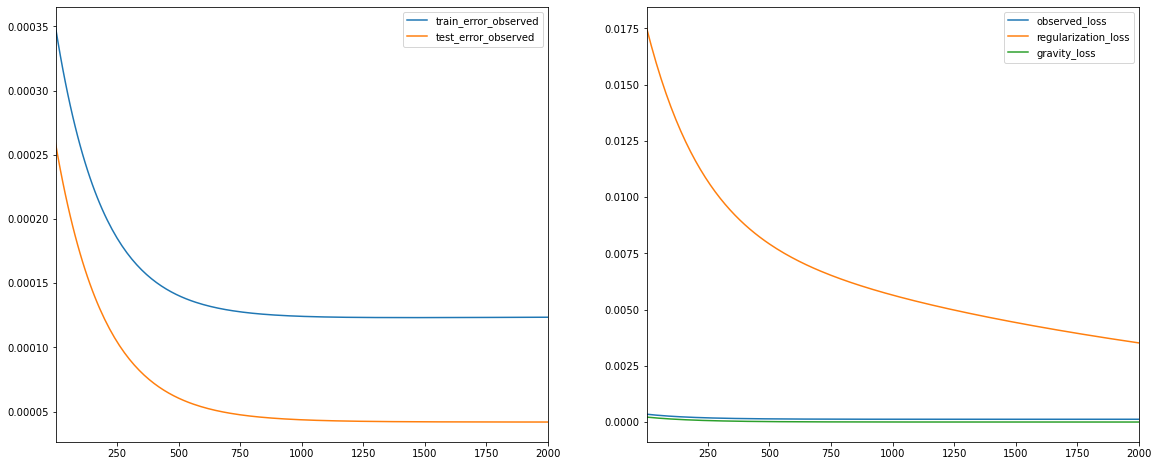

In [23]:
reg_model = build_regularized_model(
    user_artists_norm, regularization_coeff=0.1, gravity_coeff=1.0, embedding_dim=35,
    init_stddev=.05)
reg_model.train(num_iterations=2000, learning_rate=20.)

### Testing

In [24]:
artist_neighbors(model_lowinit, "Johnny Cash", DOT)
artist_neighbors(model_lowinit, "Johnny Cash", COSINE)

Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,dot score,names
712,0.099054,Johnny Cash
9476,0.074225,J. Tillman
783,0.056667,Thalía
14760,0.056656,Kuolleet Kukat
14430,0.056206,bso
11049,0.055591,Peter Hammill


Nearest neighbors of : Johnny Cash.
[Found more than one matching artist. Other candidates: Johnny Cash & Willie Nelson]


,cosine score,names
712,1.000000,Johnny Cash
9476,0.674250,J. Tillman
14430,0.623293,bso
2351,0.609271,Karnivool
1850,0.597485,Thousand Foot Krutch
16376,0.571668,The Boy Least Likely To


## Results

Our recommender system is fully functional and outputs artists based on similarity metrics to whatever artist the user enters. The system appears to have some issues as there are often useful recommendations alongside other, not so useful recommendations. The inner workings of the systems need some work before this would be deemed acceptable however as a starting point it is a useful recommender system to be further fine tuned.

# Novel Lyrics Display

This section details the novel lyrics aspect of this system. A user can input a favourite artist and song and will be returned some classic lyrics from that artist on screen.

In [25]:
pip install lyricsgenius

Note: you may need to restart the kernel to use updated packages.


In [26]:
import os
import json
import time

Token has been removed below after successfully running the API call

In [27]:
token = 'xxxxxxxxxxxxxxxxxxxxxxxxxxx'

In [28]:
import lyricsgenius as lg
genius = lg.Genius(token)

In [29]:
song_title = "Walk the line"
artist_name = "Johnny Cash"

In [30]:
song = genius.search_song(title=song_title, artist=artist_name)

Searching for "Walk the line" by Johnny Cash...


Done.


In [31]:
lyrics = song.lyrics

In [32]:
l=lyrics.split('\n')

In [33]:
for line in l:
    print(line)
    
    # uncomment for interactive notebook running
    #time.sleep(2)

[Verse 1]
I keep a close watch on this heart of mine
I keep my eyes wide open all the time
I keep the ends out for the tie that binds
Because you're mine, I walk the line

[Verse 2]
I find it very, very easy to be true
I find myself alone when each day is through
Yes, I'll admit that I'm a fool for you
Because you're mine, I walk the line

[Verse 3]
As sure as night is dark and day is light
I keep you on my mind both day and night
And happiness I've known proves that it's right
Because you're mine, I walk the line

[Verse 4]
You've got a way to keep me on your side
You give me cause for love that I can't hide
For you, I know I'd even try to turn the tide
Because you're mine, I walk the line

[Verse 1]
I keep a close watch on this heart of mine
I keep my eyes wide open all the time
I keep the ends out for the tie that binds
Because you're mine, I walk the line22EmbedShare URLCopyEmbedCopy


<img src="https://www.billboard.com/wp-content/uploads/media/johnny-cash-bw-portrait-klm-billboard-1548.jpg" width=750 height=750 />